In [313]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

# for the colormapping 
from cycler import cycler 
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['axes.prop_cycle'] = cycler(color=['r', 'orange', 'forestgreen', 'b', 'mediumorchid', 'k'])

In [314]:
def addcols(file):
    '''
    Read in a whitespace-separated file containing information about a spectroscopic light curve containing: 
        * the lower wavelength bound of the bin (bin_start)
        * the upper wavelength bound of the bin (bin_end)
        * the planet radius in stellar radii (RpRs)
        * error in planet radius (RpRs_err)
        * the slope of the transit in that bin (slope)
        * the slope error (slope_err)
    and append
        * the wavelength midpoint of the bin (bin_mid)
        * the slope in parts per million per hour (slope_ppm_hour)
        * the slope error in ppm/h (slope_err_ppm_hour).
    Overwrite the original file with the result. 
    '''
    df = pd.read_csv(file, sep='\s+')

    mid = (df.bin_start+df.bin_end)/2 # midpoint of the bin
    slopeppm = df.slope*1e6/24 # slope in parts per million
    slopeerrppm = df.slope_err*1e6/24 # slope error in parts per million
    df['bin_mid']=mid
    df['slope_ppm_hour']=slopeppm
    df['slope_err_ppm_hour']=slopeerrppm
    df.to_csv(file, sep='\t')

In [315]:
names=['hatp1b', 'hatp26b', 'toi134b', 'wasp63b', 'wasp107b', 'wasp178b']

for i in names:
    # add the columns described above to the slopes.csv file stored in each target's folder, once for each detector
    addcols('./outputs/'+i+'-nrs1/slopes.csv')
    addcols('./outputs/'+i+'-nrs2/slopes.csv')

In [316]:
# get the bin and slope information for each target for each detector
h1n1 = pd.read_csv('./outputs/hatp1b-nrs1/slopes.csv', sep='\s+')
h1n2 = pd.read_csv('./outputs/hatp1b-nrs2/slopes.csv', sep='\s+')
h26n1 = pd.read_csv('./outputs/hatp26b-nrs1/slopes.csv', sep='\s+')
h26n2 = pd.read_csv('./outputs/hatp26b-nrs2/slopes.csv', sep='\s+')
t134n1 = pd.read_csv('./outputs/toi134b-nrs1/slopes.csv', sep='\s+')
t134n2 = pd.read_csv('./outputs/toi134b-nrs2/slopes.csv', sep='\s+')
w63n1 = pd.read_csv('./outputs/wasp63b-nrs1/slopes.csv', sep='\s+')
w63n2 = pd.read_csv('./outputs/wasp63b-nrs2/slopes.csv', sep='\s+')
w107n1 = pd.read_csv('./outputs/wasp107b-nrs1/slopes.csv', sep='\s+')
w107n2 = pd.read_csv('./outputs/wasp107b-nrs2/slopes.csv', sep='\s+')
w178n1 = pd.read_csv('./outputs/wasp178b-nrs1/slopes.csv', sep='\s+')
w178n2 = pd.read_csv('./outputs/wasp178b-nrs2/slopes.csv', sep='\s+')

In [317]:
# read in a .csv file containing each target's name, V magnitude, J magnitude, K magnitude, 
# stellar effective temperature, planet radius in solar radii, groups per integration, 
# number of integrations, and exposure start time. once per target is sufficient here, 
# since this does not vary by detector. this is more information than is actually used below;
# only J mag, groups per integration, and number of integrations are strictly necessary. 

params = pd.read_csv('params.csv')
params

,names,v_mag,j_mag,k_mag,Teff,R_p,groups,integrations,exposure_start
0,hatp1b,9.8,9.156,8.9,5980,1.3190,19,1336,60632.568483
1,hatp26b,11.8,10.080,9.6,5079,0.6300,48,481,60110.173536
2,toi134b,11.0,7.941,7.1,3842,0.1454,4,3359,60113.791180
3,wasp63b,11.2,9.818,9.4,5550,1.4100,33,1351,60706.136833
4,wasp107b,11.6,9.378,8.6,4425,0.9400,6,4789,60487.394667
5,wasp178b,9.9,9.775,9.7,9360,1.8100,45,605,60010.334594


In [318]:
dfs = [h1n1, h1n2, h26n1, h26n2, t134n1, t134n2, w63n1, w63n2, w107n1, w107n2, w178n1, w178n2] #make a list of all the slope dataframes 

# sigma cut; mask out all indices in each dataframe where the slope of a specific bin is more than 3 
# times the slope's stadard deviation away from the average slope.
sigma = 3 
for i in dfs:
    slopeavg=np.mean(i.slope_ppm_hour)
    slopesd=np.std(i.slope_ppm_hour)
    i['slope_mask']=((i.slope_ppm_hour>(sigma*slopesd)+slopeavg) | ((i.slope_ppm_hour<slopeavg-(sigma*slopesd))))

In [319]:
nrs1 = [h1n1, h26n1, t134n1, w63n1, w107n1, w178n1] #list of nrs1 data
nrs2 = [h1n2, h26n2, t134n2, w63n2, w107n2, w178n2] #list of nrs2 data
prettynames = ['HAT-P-1 b', 'HAT-P-26 b', 'TOI-134 b', 'WASP-63 b', 'WASP-107 b', 'WASP-178 b'] #correctly punctuated and capitalized names for labels
params['prettynames']=prettynames

# apologies for this being kind of a mess. add a column for each detector to the 6 row dataframe, and 
# store the dataframe with slope information for each detector and each planet in there; access 
# HAT-P-1 b's NRS1 observation (for instance) with params.nrs1[0]
params['nrs1']=nrs1 
params['nrs2']=nrs2
params.nrs1[0]

,bin_start,bin_end,RpRs,RpRs_err,slope,slope_err,bin_mid,slope_ppm_hour,slope_err_ppm_hour,slope_mask
0,2.862704,2.903259,0.118700,0.000159,-0.001230,0.000208,2.882981,-51.235959,8.647024,False
1,2.903259,2.943814,0.118571,0.000154,-0.001221,0.000201,2.923536,-50.857109,8.363839,False
2,2.943814,2.984369,0.118283,0.000145,-0.001404,0.000188,2.964091,-58.490089,7.825551,False
3,2.984369,3.024923,0.117956,0.000134,-0.001816,0.000174,3.004646,-75.660512,7.235284,False
4,3.024923,3.065478,0.117952,0.000138,-0.001861,0.000179,3.045201,-77.552660,7.455403,False
5,3.065478,3.106033,0.117836,0.000140,-0.001967,0.000181,3.085756,-81.978875,7.550256,False
6,3.106033,3.146588,0.117902,0.000136,-0.002177,0.000176,3.126311,-90.696417,7.329446,False
7,3.146588,3.187143,0.117489,0.000135,-0.002991,0.000174,3.166865,-124.624934,7.253442,False
8,3.187143,3.227698,0.117813,0.000142,-0.002288,0.000183,3.207420,-95.326772,7.637085,False
9,3.227698,3.268253,0.117383,0.000143,-0.002524,0.000184,3.247975,-105.182820,7.650657,False


# J Mag
Make the overlaid, stacked, side-by-side, and individual plots for each planet, color-coded and ordered by J magnitude.

Text(0.5, 0.01, 'Wavelength ($\\mu$m)')

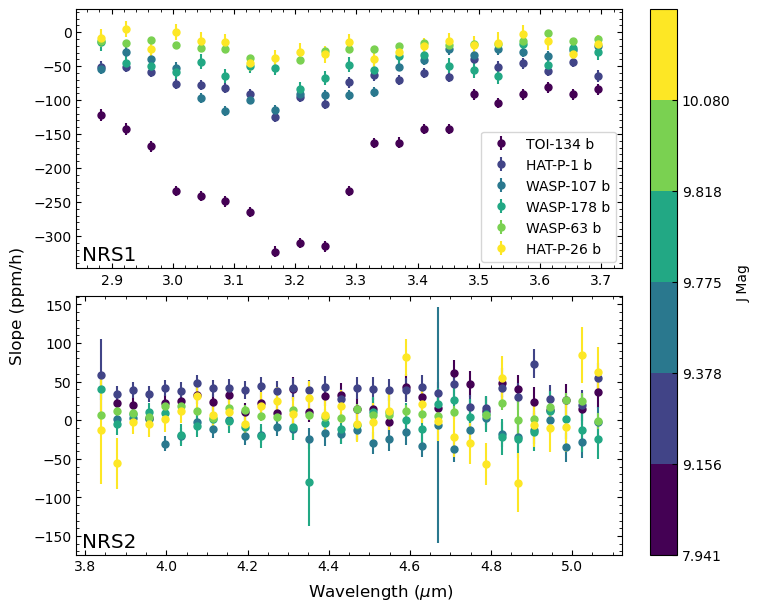

In [320]:
fig, (ax1, ax2) = plt.subplots(2,1, layout="constrained")
fig.set_figheight(6)
fig.set_figwidth(7.5)

#ensure the targets are plotted in order of J magnitude, and set the boundaries of each color on the colorbar. 
params = params.sort_values(by='j_mag', ignore_index=True)
c=params.j_mag
boundaries=c.copy().tolist()
boundaries.append(10.085)

# get discrete colors from a colorbar 
cmap = mpl.colormaps['viridis']
norm = mcolors.BoundaryNorm(boundaries, cmap.N)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(c) # Set the array of values to map to color

for i in range(len(params)):
    # plot slope against mid-bin wavelength for each planet; nrs1 in the top panel and nrs2 in the bottom panel. 
    ax1.errorbar(params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask], params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

    ax2.errorbar(params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

cb = fig.colorbar(sm, ax=(ax1,ax2), ticks=c, label='J Mag')
cb.ax.minorticks_off()

ax1.text(.01,.03,'NRS1', size='x-large', transform=ax1.transAxes)
ax2.text(.01,.03,'NRS2', size='x-large', transform=ax2.transAxes)

ax1.legend(ncols=1)
fig.supylabel('Slope (ppm/h)')
fig.supxlabel(r'Wavelength ($\mu$m)')

Text(0.5, 0.01, 'Wavelength ($\\mu$m)')

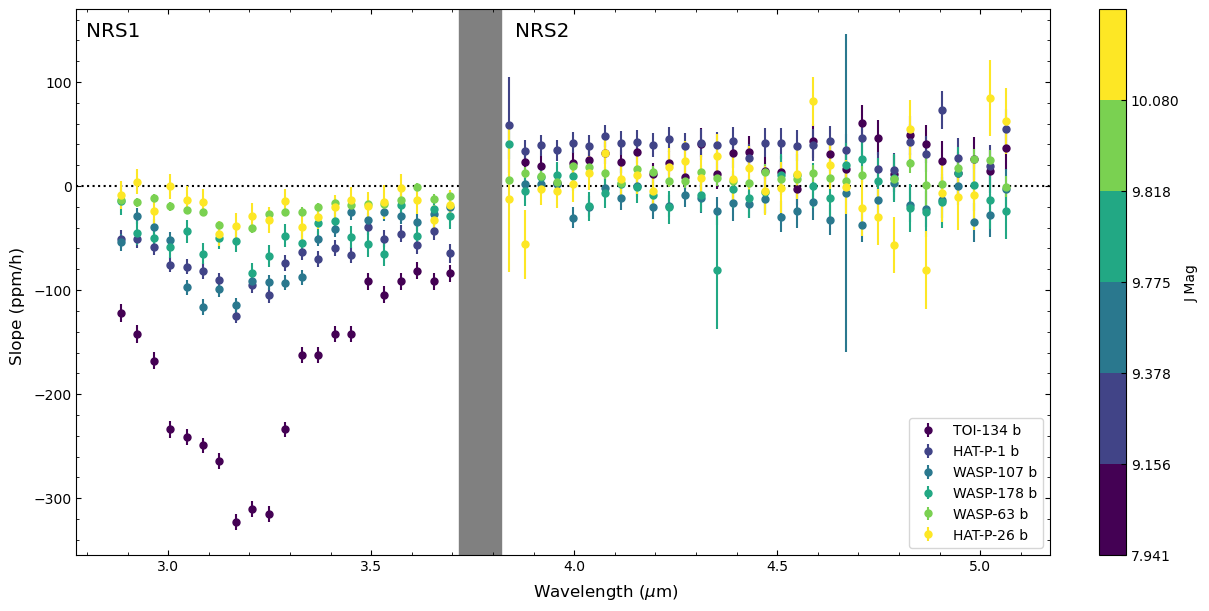

In [321]:
fig, ax = plt.subplots(1,1, layout="constrained")
fig.set_figheight(6)
fig.set_figwidth(12)

for i in range(len(params)):
    #concatenate nrs1 and nrs2 data for each target to plot them side-by-side
    wl = np.concatenate((params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask]))
    slp = np.concatenate((params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask]))
    err = np.concatenate((params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask]))

    ax.errorbar(wl, slp, err, color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

cb = fig.colorbar(sm, ax=ax, ticks=c, label='J Mag')
cb.ax.minorticks_off()

ax.text(.01,.95,'NRS1', size='x-large', transform=ax.transAxes)
ax.text(.45,.95,'NRS2', size='x-large', transform=ax.transAxes)

ax.axvspan(3.716, 3.82, ax.get_ylim()[0], ax.get_ylim()[1], color='gray')
ax.axhline(0, c='k', ls=':', zorder=0)

ax.legend(loc='lower right')
fig.supylabel('Slope (ppm/h)')
fig.supxlabel(r'Wavelength ($\mu$m)')

Text(0.5, 0.01, 'Wavelength($\\mu$m)')

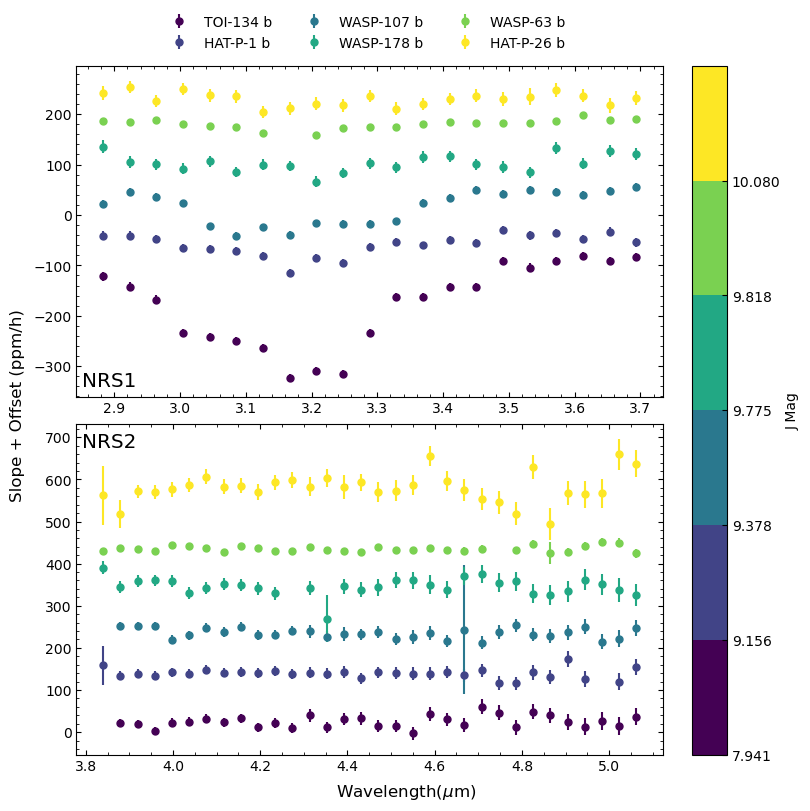

In [322]:
fig, (ax1, ax2) = plt.subplots(2,1, layout="constrained")
fig.set_figheight(8)
fig.set_figwidth(8)

offset1=[0,10,75,150,200,250]
offset2=[0,100,250,350,425,575]

for i in range(len(params)):
    # plot slope against mid-bin wavelength for each planet; nrs1 in the top panel and nrs2 in the bottom panel. add an offset to compare the shapes more clearly
    ax1.errorbar(params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask]+offset1[i], params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)
    ax2.errorbar(params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask]+offset2[i], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

ax1.text(.01,.03,'NRS1', size='x-large', transform=ax1.transAxes)
ax2.text(.01,.93,'NRS2', size='x-large', transform=ax2.transAxes)

cb = fig.colorbar(sm, ax=(ax1,ax2), ticks=c, label='J Mag')
cb.ax.minorticks_off()

ax1.legend(ncols=3, bbox_to_anchor=(.13,1.01), frameon=False)
fig.supylabel('Slope + Offset (ppm/h)')
fig.supxlabel(r'Wavelength($\mu$m)')

Text(0.5, 0.01, 'Wavelength($\\mu$m)')

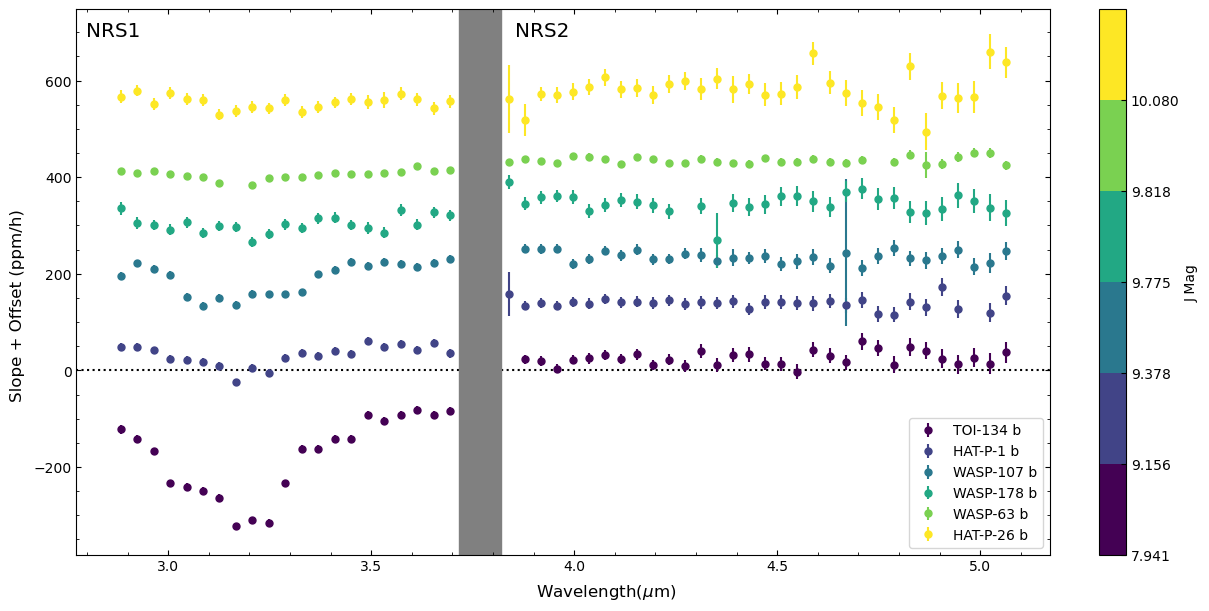

In [323]:
fig, ax = plt.subplots(1,1, layout="constrained")
fig.set_figheight(6)
fig.set_figwidth(12)

offset=[0,100,250,350,425,575]

for i in range(len(params)):
    #concatenate nrs1 and nrs2 data for each target to plot them side-by-side; add an offset to compare the shapes more clearly
    wl = np.concatenate((params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask]))
    slp = np.concatenate((params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask]))
    err = np.concatenate((params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask]))

    ax.errorbar(wl, slp+offset[i], err, color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

cb = fig.colorbar(sm, ax=ax, ticks=c, label='J Mag')
cb.ax.minorticks_off()

ax.text(.01,.95,'NRS1', size='x-large', transform=ax.transAxes)
ax.text(.45,.95,'NRS2', size='x-large', transform=ax.transAxes)

ax.axvspan(3.716, 3.82, ax.get_ylim()[0], ax.get_ylim()[1], color='gray')
ax.axhline(0, c='k', ls=':', zorder=0)

ax.legend()
fig.supylabel('Slope + Offset (ppm/h)')
fig.supxlabel(r'Wavelength($\mu$m)')

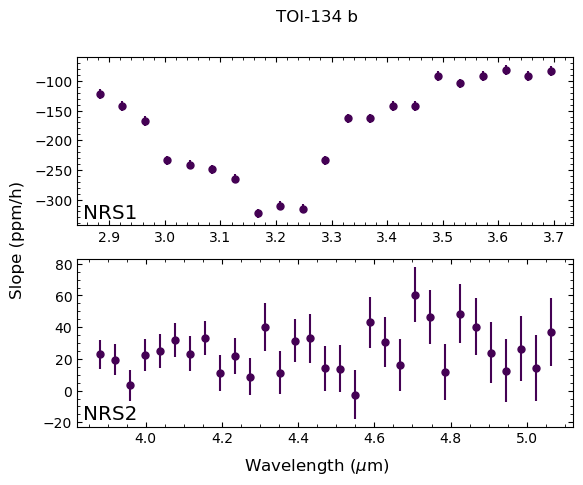

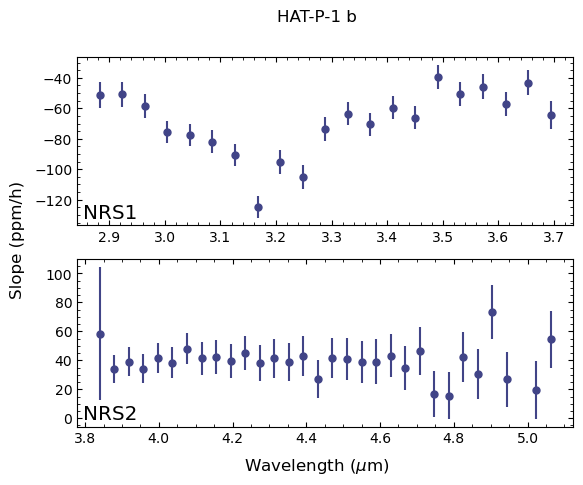

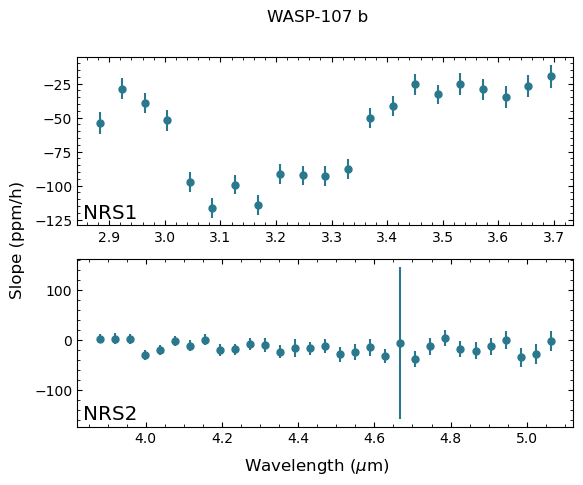

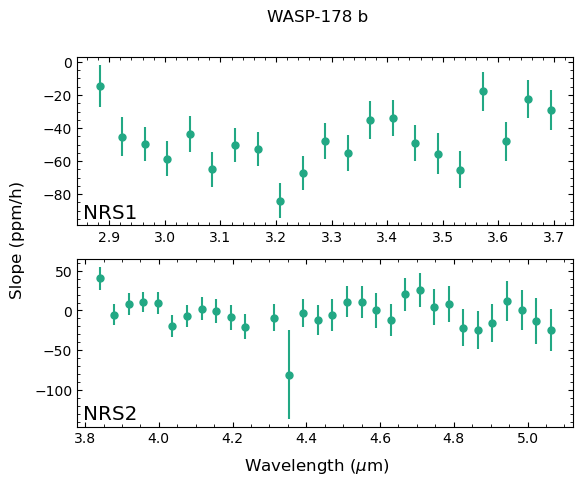

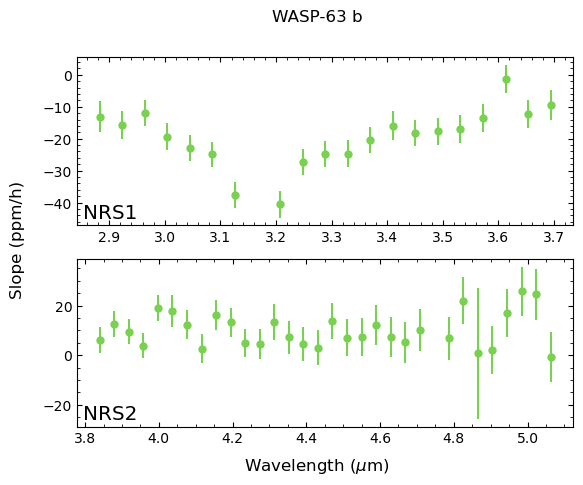

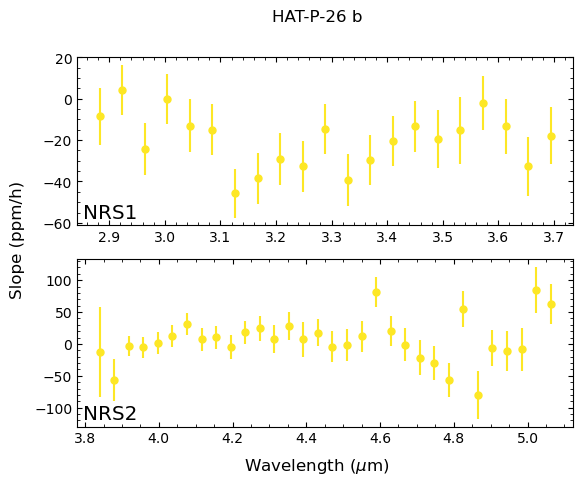

In [324]:
for i in range(len(params)):
    # plot slope against mid-bin wavelength for each planet separately
    fig, (ax1, ax2) = plt.subplots(2,1)

    ax1.errorbar(params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask], params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', ms=5)
    ax2.errorbar(params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', ms=5)

    ax1.text(.0125,.0425,'NRS1', size='x-large', transform=ax1.transAxes)
    ax2.text(.0125,.0425,'NRS2', size='x-large', transform=ax2.transAxes)

    fig.supylabel('Slope (ppm/h)')
    fig.supxlabel(r'Wavelength ($\mu$m)')
    fig.suptitle(params.prettynames[i])

# Number of Integrations
Make the overlaid, stacked, side-by-side, and individual plots for each planet, color-coded and ordered by number of integrations.

Text(0.5, 0.01, 'Wavelength ($\\mu$m)')

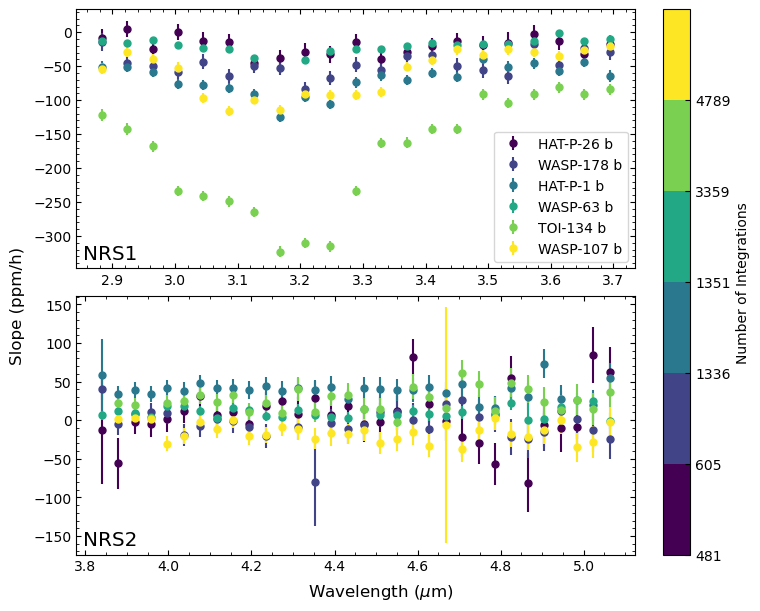

In [325]:
fig, (ax1, ax2) = plt.subplots(2,1, layout="constrained")
fig.set_figheight(6)
fig.set_figwidth(7.5)

#ensure the targets are plotted in order of number of integrations, and set the boundaries of each color on the colorbar. 
params = params.sort_values(by='integrations', ignore_index=True)
c=params.integrations
boundaries=c.copy().tolist()
boundaries.append(5000)

# get discrete colors from a colorbar 
cmap = mpl.colormaps['viridis'] 
norm = mcolors.BoundaryNorm(boundaries, cmap.N)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(c) # Set the array of values to map to color

for i in range(len(params)):
    # plot slope against mid-bin wavelength for each planet; nrs1 in the top panel and nrs2 in the bottom panel. 
    ax1.errorbar(params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask], params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

    ax2.errorbar(params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

cb = fig.colorbar(sm, ax=(ax1,ax2), ticks=c, label='Number of Integrations')
cb.ax.minorticks_off()

ax1.text(.0125,.035,'NRS1', size='x-large', transform=ax1.transAxes)
ax2.text(.0125,.035,'NRS2', size='x-large', transform=ax2.transAxes)

ax1.legend(ncols=1)
fig.supylabel('Slope (ppm/h)')
fig.supxlabel(r'Wavelength ($\mu$m)')

Text(0.5, 0.01, 'Wavelength($\\mu$m)')

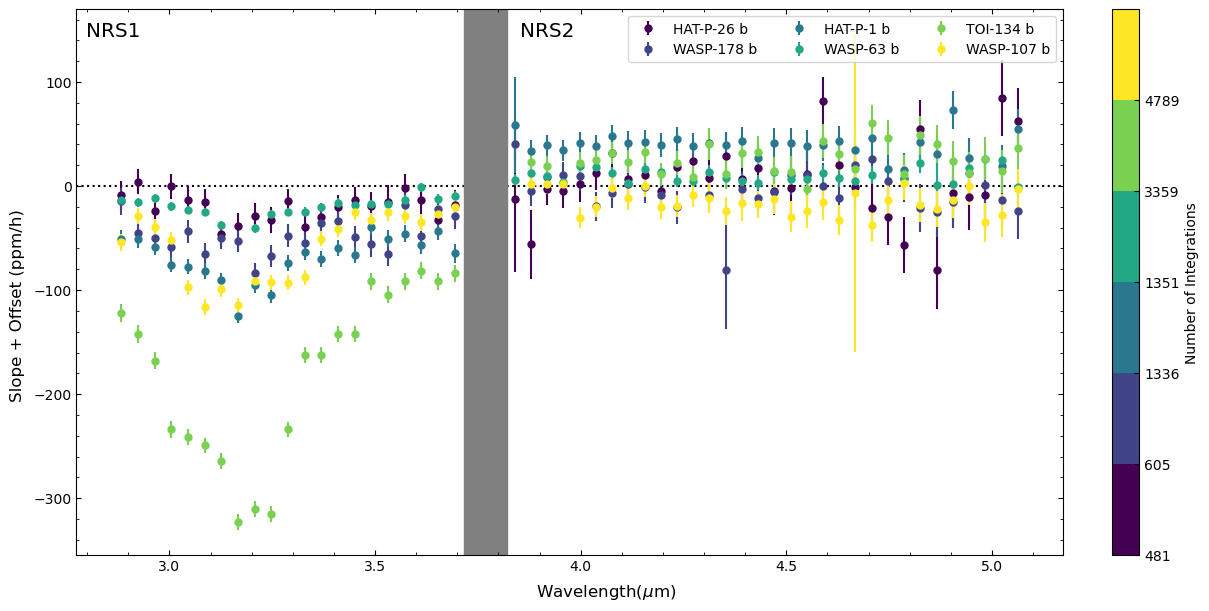

In [326]:
fig, ax = plt.subplots(1,1, layout="constrained")
fig.set_figheight(6)
fig.set_figwidth(12)

for i in range(len(params)):
    #concatenate nrs1 and nrs2 data for each target to plot them side-by-side
    wl = np.concatenate((params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask]))
    slp = np.concatenate((params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask]))
    err = np.concatenate((params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask]))

    ax.errorbar(wl, slp, err, color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

cb = fig.colorbar(sm, ax=ax, ticks=c, label='Number of Integrations')
cb.ax.minorticks_off()

ax.text(.01,.95,'NRS1', size='x-large', transform=ax.transAxes)
ax.text(.45,.95,'NRS2', size='x-large', transform=ax.transAxes)

ax.axvspan(3.716, 3.82, ax.get_ylim()[0], ax.get_ylim()[1], color='gray')
ax.axhline(0, c='k', ls=':', zorder=0)

ax.legend(ncols=3)
fig.supylabel('Slope + Offset (ppm/h)')
fig.supxlabel(r'Wavelength($\mu$m)')

Text(0.5, 0.01, 'Wavelength ($\\mu$m)')

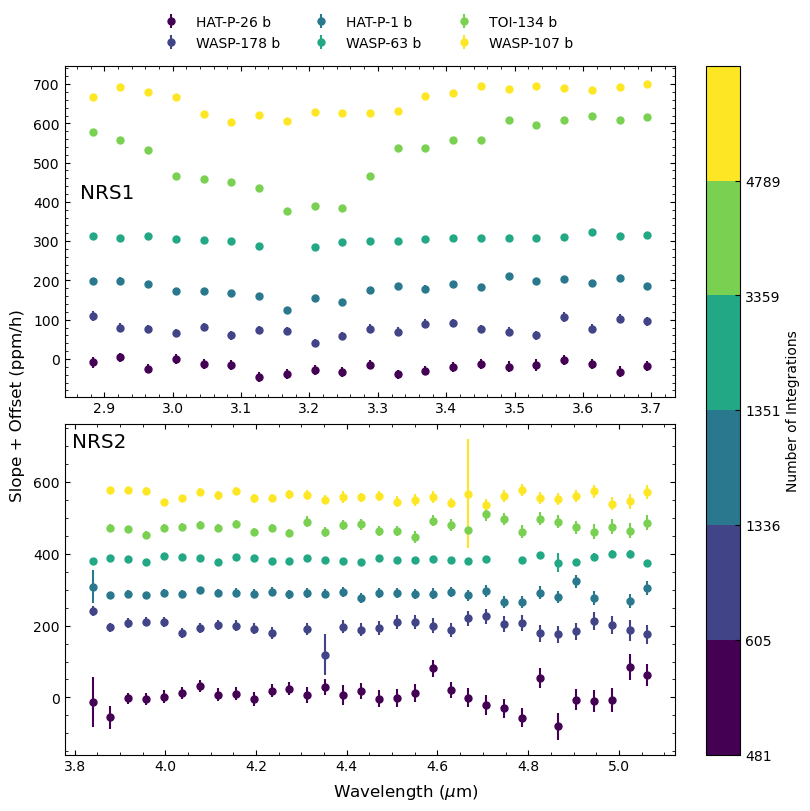

In [327]:
fig, (ax1, ax2) = plt.subplots(2,1, layout="constrained")
fig.set_figheight(8)
fig.set_figwidth(8)

offset1=[0,125,250,325,700,720]
offset2=[0,200,250,375,450,575]

for i in range(len(params)):    
    # plot slope against mid-bin wavelength for each planet; nrs1 in the top panel and nrs2 in the bottom panel. add an offset to compare the shapes more clearly
    ax1.errorbar(params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask]+offset1[i], params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

    ax2.errorbar(params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask]+offset2[i], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

ax1.text(.025,.6,'NRS1', size='x-large', transform=ax1.transAxes)
ax2.text(.0125,.93,'NRS2', size='x-large', transform=ax2.transAxes)

cb = fig.colorbar(sm, ax=(ax1,ax2), ticks=c, label='Number of Integrations')
cb.ax.minorticks_off()

ax1.legend(ncols=3, bbox_to_anchor=(.13,1.01), frameon=False)
fig.supylabel('Slope + Offset (ppm/h)')
fig.supxlabel(r'Wavelength ($\mu$m)')

Text(0.5, 0.01, 'Wavelength($\\mu$m)')

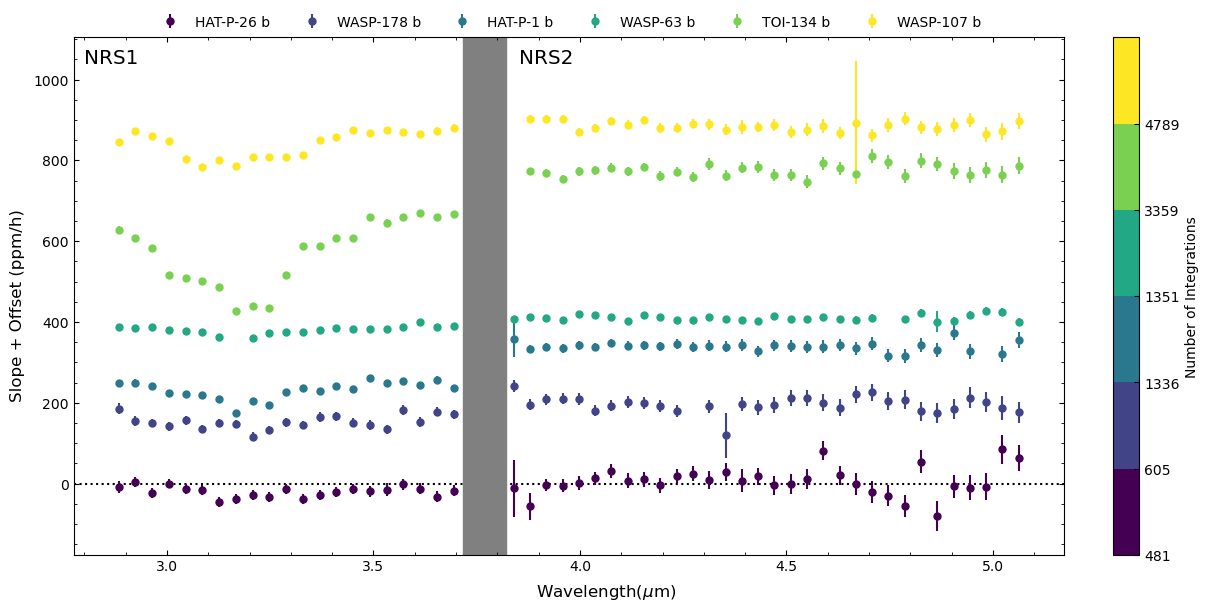

In [328]:
fig, ax = plt.subplots(1,1, layout="constrained")
fig.set_figheight(6)
fig.set_figwidth(12)

offset=[0,200,300,400,750,900]

for i in range(len(params)):
    #concatenate nrs1 and nrs2 data for each target to plot them side-by-side; add an offset to compare the shapes more clearly
    wl = np.concatenate((params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask]))
    slp = np.concatenate((params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask]))
    err = np.concatenate((params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask]))

    ax.errorbar(wl, slp+offset[i], err, color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

cb = fig.colorbar(sm, ax=ax, ticks=c, label='Number of Integrations')
cb.ax.minorticks_off()

ax.text(.01,.95,'NRS1', size='x-large', transform=ax.transAxes)
ax.text(.45,.95,'NRS2', size='x-large', transform=ax.transAxes)

ax.axvspan(3.716, 3.82, ax.get_ylim()[0], ax.get_ylim()[1], color='gray')
ax.axhline(0, c='k', ls=':', zorder=0)

ax.legend(ncols=6, loc='center', bbox_to_anchor=(0.5, 1.03), frameon=False)
fig.supylabel('Slope + Offset (ppm/h)')
fig.supxlabel(r'Wavelength($\mu$m)')

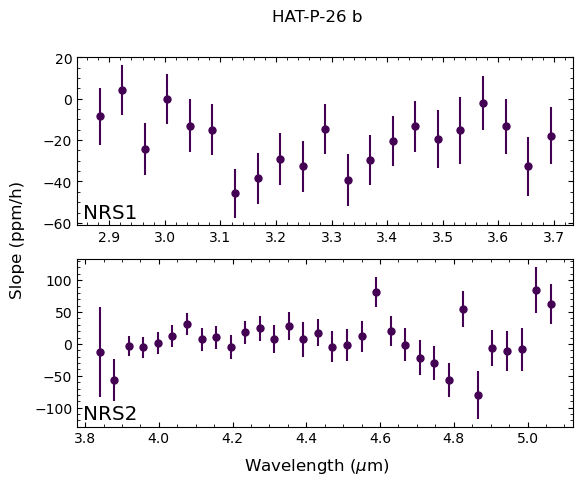

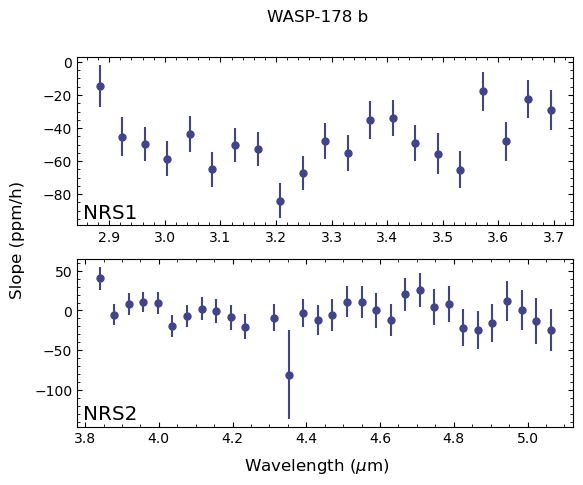

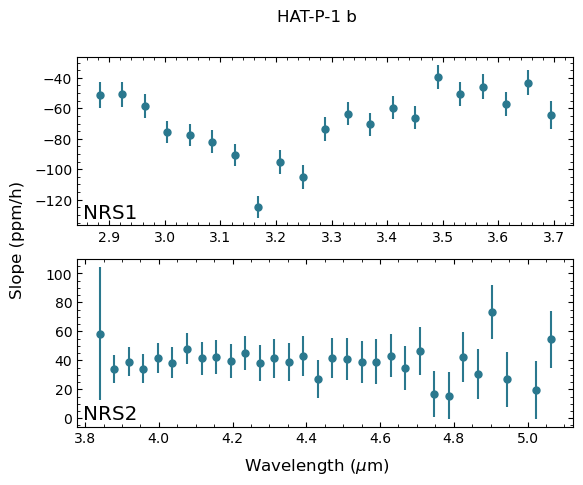

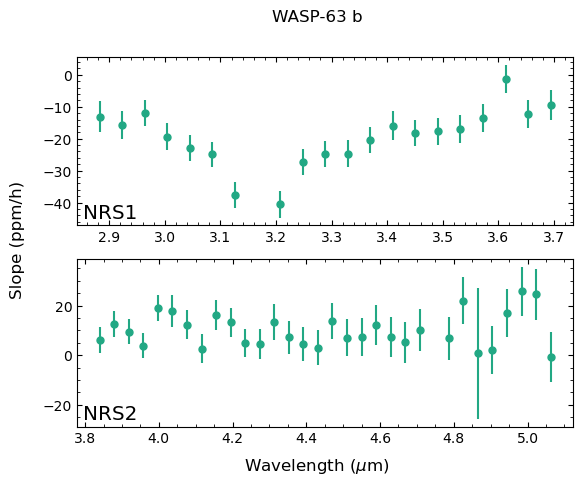

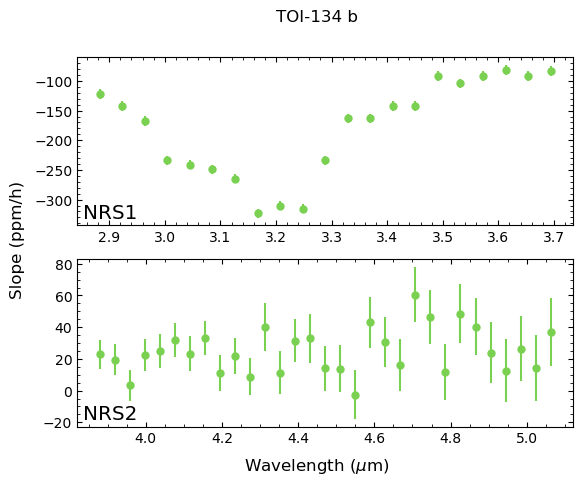

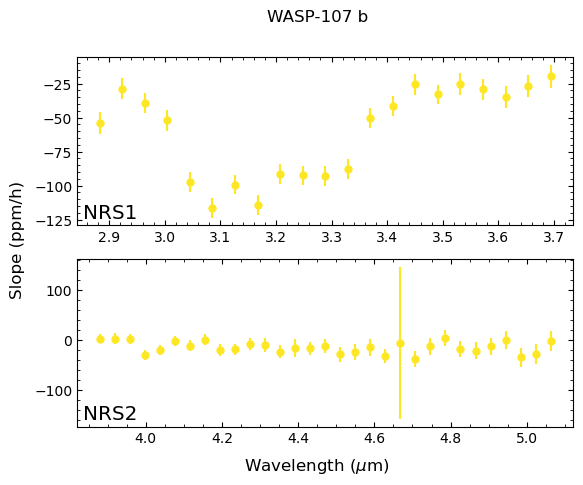

In [329]:
for i in range(len(params)):
    # plot slope against mid-bin wavelength for each planet separately
    fig, (ax1, ax2) = plt.subplots(2,1)

    ax1.errorbar(params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask], params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', ms=5)

    ax2.errorbar(params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', ms=5)

    ax1.text(.0125,.0425,'NRS1', size='x-large', transform=ax1.transAxes)
    ax2.text(.0125,.0425,'NRS2', size='x-large', transform=ax2.transAxes)

    fig.supylabel('Slope (ppm/h)')
    fig.supxlabel(r'Wavelength ($\mu$m)')
    fig.suptitle(params.prettynames[i])

# Groups per Integration
Make the overlaid, stacked, side-by-side, and individual plots for each planet, color-coded and ordered by groups per integration.

Text(0.5, 0.01, 'Wavelength ($\\mu$m)')

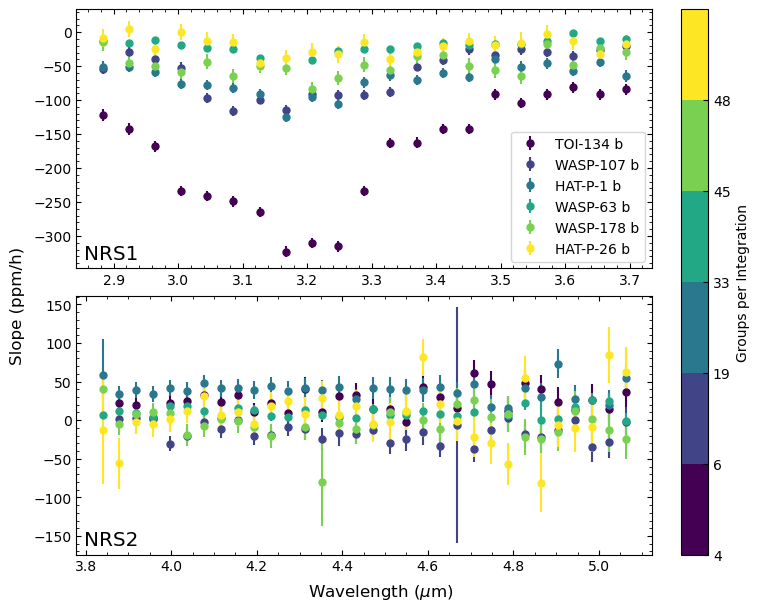

In [330]:
fig, (ax1, ax2) = plt.subplots(2,1, layout="constrained")
fig.set_figheight(6)
fig.set_figwidth(7.5)

#ensure the targets are plotted in order of groups per integration, and set the boundaries of each color on the colorbar. 
params = params.sort_values(by='groups', ignore_index=True)
c=params.groups
boundaries=c.copy().tolist()
boundaries.append(50)

# get discrete colors from a colorbar 
cmap = mpl.colormaps['viridis']  # tab10 has 10 unique colors
norm = mcolors.BoundaryNorm(boundaries, cmap.N)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(c) # Set the array of values to map to color

for i in range(len(params)):
    # plot slope against mid-bin wavelength for each planet; nrs1 in the top panel and nrs2 in the bottom panel. 
    ax1.errorbar(params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask], params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], 
                 color=cmap(norm(c[i])), label=params.prettynames[i], fmt='o', ms=5)

    ax2.errorbar(params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask], 
                 color=cmap(norm(c[i])), label=params.prettynames[i], fmt='o', ms=5)

cb = fig.colorbar(sm, ax=(ax1,ax2), ticks=c, label='Groups per Integration')
cb.ax.minorticks_off()

ax1.text(.0125,.035,'NRS1', size='x-large', transform=ax1.transAxes)
ax2.text(.0125,.035,'NRS2', size='x-large', transform=ax2.transAxes)

ax1.legend(ncols=1)
fig.supylabel('Slope (ppm/h)')
fig.supxlabel(r'Wavelength ($\mu$m)')

Text(0.5, 0.01, 'Wavelength($\\mu$m)')

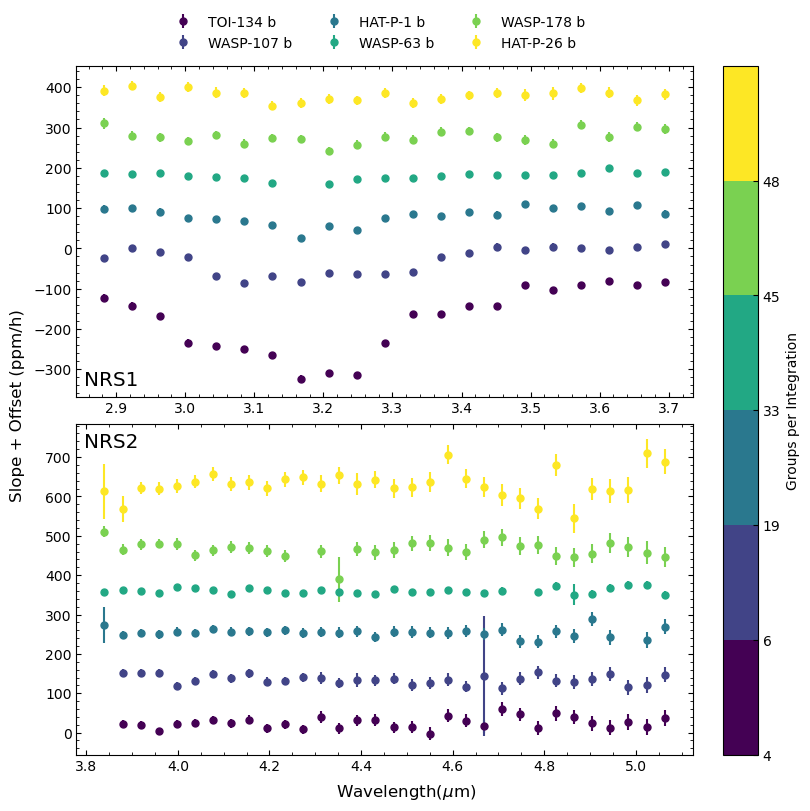

In [331]:
fig, (ax1, ax2) = plt.subplots(2,1, layout="constrained")
fig.set_figheight(8)
fig.set_figwidth(8)

offset1=[0,30,150,200,325,400]
offset2=[0,150,215,350,470,625]

for i in range(len(params)):
    # plot slope against mid-bin wavelength for each planet; nrs1 in the top panel and nrs2 in the bottom panel. add an offset to compare the shapes more clearly
    ax1.errorbar(params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask]+offset1[i], params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], 
                 color=cmap(norm(c[i])), label=params.prettynames[i], fmt='o', ms=5)

    ax2.errorbar(params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask]+offset2[i], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask], 
                 color=cmap(norm(c[i])), label=params.prettynames[i], fmt='o', ms=5)

ax1.text(.0125,.035,'NRS1', size='x-large', transform=ax1.transAxes)
ax2.text(.0125,.93,'NRS2', size='x-large', transform=ax2.transAxes)

cb = fig.colorbar(sm, ax=(ax1,ax2), ticks=c, label='Groups per Integration')
cb.ax.minorticks_off()

ax1.legend(ncols=3, bbox_to_anchor=(.13,1.01), frameon=False)
fig.supylabel('Slope + Offset (ppm/h)')
fig.supxlabel(r'Wavelength($\mu$m)')

Text(0.5, 0.01, 'Wavelength($\\mu$m)')

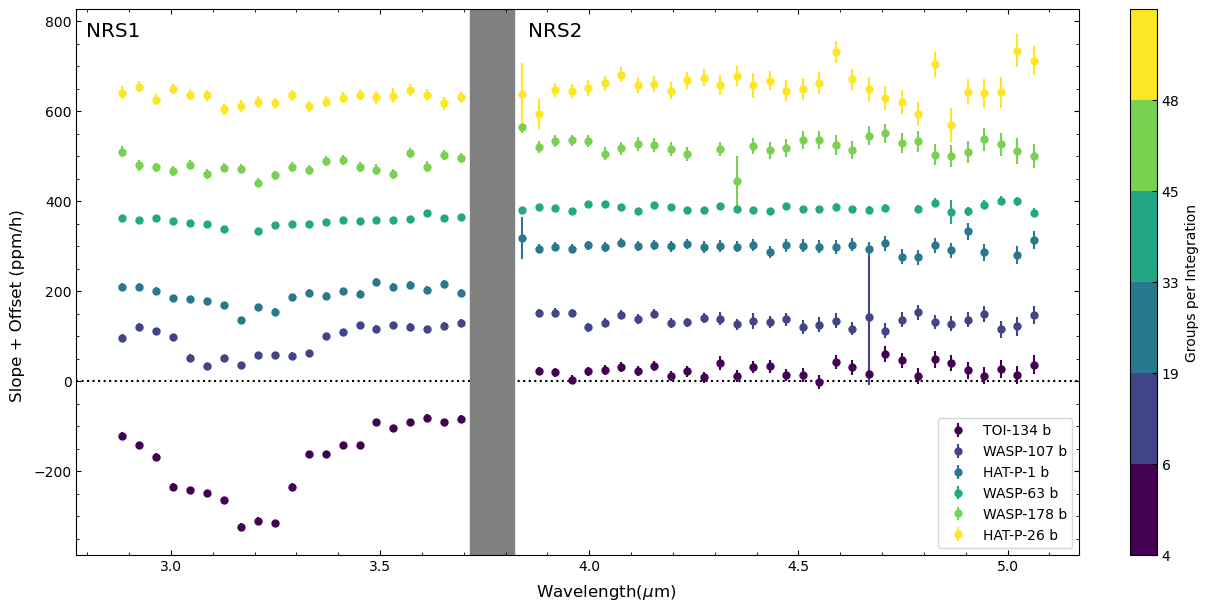

In [332]:
fig, ax = plt.subplots(1,1, layout="constrained")
fig.set_figheight(6)
fig.set_figwidth(12)

offset=[0,150,260,375,525,650]

for i in range(len(params)):
    #concatenate nrs1 and nrs2 data for each target to plot them side-by-side; add an offset to compare the shapes more clearly
    wl = np.concatenate((params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask]))
    slp = np.concatenate((params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask]))
    err = np.concatenate((params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask]))

    ax.errorbar(wl, slp+offset[i], err, color=cmap(norm(c[i])), fmt='o', label=params.prettynames[i], ms=5)

cb = fig.colorbar(sm, ax=ax, ticks=c, label='Groups per Integration')
cb.ax.minorticks_off()

ax.text(.01,.95,'NRS1', size='x-large', transform=ax.transAxes)
ax.text(.45,.95,'NRS2', size='x-large', transform=ax.transAxes)

ax.axvspan(3.716, 3.82, ax.get_ylim()[0], ax.get_ylim()[1], color='gray')
ax.axhline(0, c='k', ls=':', zorder=0)

ax.legend(ncols=1)
fig.supylabel('Slope + Offset (ppm/h)')
fig.supxlabel(r'Wavelength($\mu$m)')

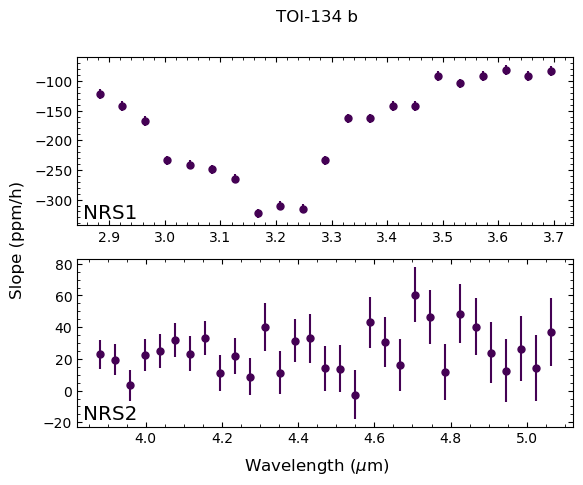

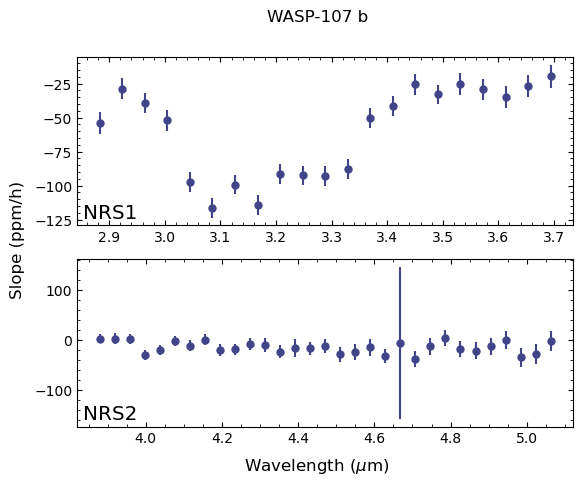

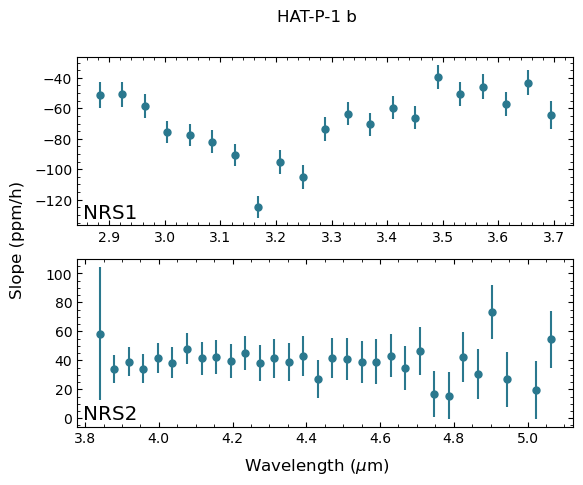

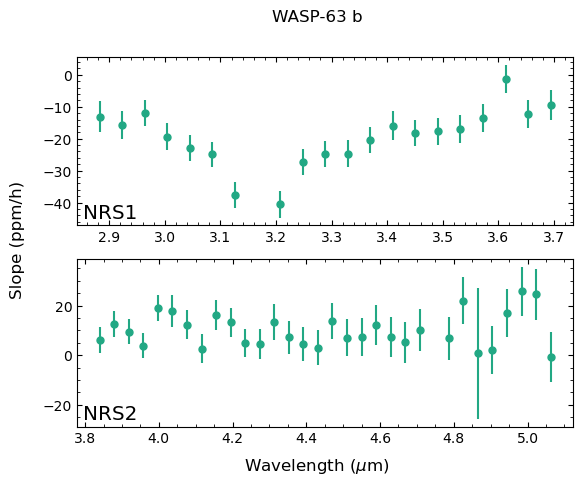

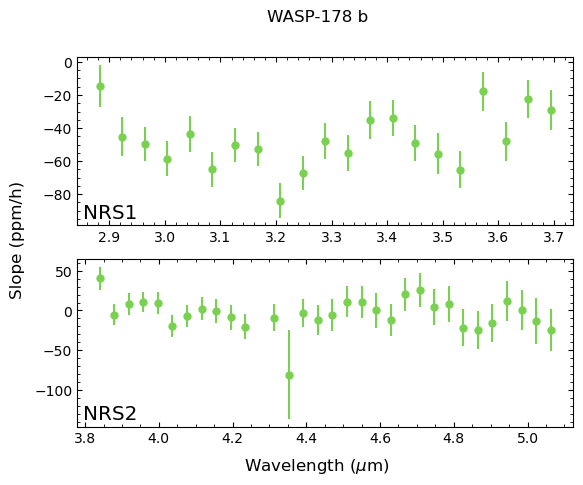

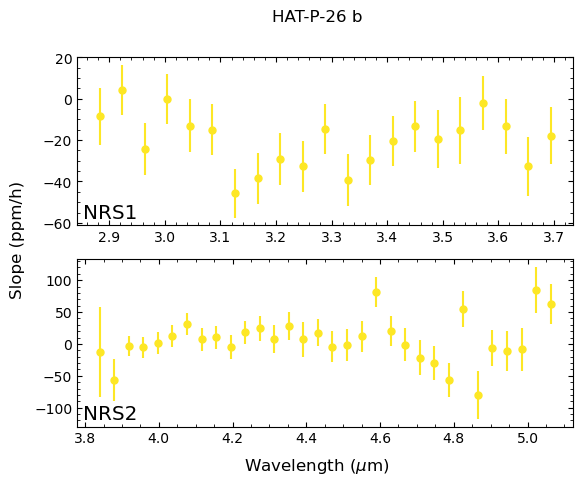

In [333]:
for i in range(len(params)):
    # plot slope against mid-bin wavelength for each planet separately
    fig, (ax1, ax2) = plt.subplots(2,1)

    ax1.errorbar(params.nrs1[i].bin_mid[~params.nrs1[i].slope_mask], params.nrs1[i].slope_ppm_hour[~params.nrs1[i].slope_mask], params.nrs1[i].slope_err_ppm_hour[~params.nrs1[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', ms=5)

    ax2.errorbar(params.nrs2[i].bin_mid[~params.nrs2[i].slope_mask], params.nrs2[i].slope_ppm_hour[~params.nrs2[i].slope_mask], params.nrs2[i].slope_err_ppm_hour[~params.nrs2[i].slope_mask], 
                 color=cmap(norm(c[i])), fmt='o', ms=5)

    ax1.text(.0125,.0425,'NRS1', size='x-large', transform=ax1.transAxes)
    ax2.text(.0125,.0425,'NRS2', size='x-large', transform=ax2.transAxes)

    fig.supylabel('Slope (ppm/h)')
    fig.supxlabel(r'Wavelength ($\mu$m)')
    fig.suptitle(params.prettynames[i])